In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import pandas_profiling

from sklearn.linear_model import LogisticRegression #logistic
from sklearn.svm import SVC #svc
from sklearn.neighbors import NearestNeighbors #knnc
from sklearn import tree #Naive tree method
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel


# from xgboost import XGBClassifier #xgboost
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%matplotlib inline

# Prepare the Dataset

In [2]:
train_df = pd.read_csv('train.csv', index_col='ID')
test_df = pd.read_csv('test.csv', index_col='ID')

train_label = pd.read_csv('train_label.csv',
                      parse_dates=['arrival_date'],
                      infer_datetime_format=True,
                      index_col='arrival_date')

convert_type = {
    'agent': 'category',
    'company': 'category'
}

# is_canceled = train_df['is_canceled']
# adr = train_df['adr']
# train_df.drop(columns=['is_canceled', 'adr', 'reservation_status', 'reservation_status_date'],
#               inplace=True)


X = pd.concat([train_df.drop(columns=['is_canceled', 'adr']),
               test_df], axis=0)

In [3]:
# save the datetime
X_datetime = X['arrival_date_year'].map(str) + '/' + X['arrival_date_month'] + '/' + X['arrival_date_day_of_month'].map(str)
X_datetime = pd.to_datetime(X_datetime, format='%Y/%B/%d').dt.strftime('%Y/%m/%d').str.replace('/0', '/')
X_datetime.rename('datetime', inplace=True)
X_datetime.loc[train_df.index].to_csv('train_datetime.csv')
X_datetime.loc[test_df.index].to_csv('test_datetime.csv')

In [4]:
convert_type = {
    'agent': 'object',
    'company': 'object'
}

train_df = train_df.astype(convert_type)
train_df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

# Outlier Detection

* ID 31980 in training dataset has abnormal adr. Drop the outlier here.


In [5]:
train_df.drop([31980], inplace=True)

# EDA

$Revenue=(1-is\_canceled)*adr*(stays\_in\_weekend\_nights+stays\_in\_week\_nights)$

In [6]:
rev_df = pd.read_csv('train_datetime.csv', index_col='ID')
rev_df['datetime'] = pd.to_datetime(rev_df['datetime'])
rev = (train_df.stays_in_weekend_nights+train_df.stays_in_week_nights) * train_df.adr * (1 - train_df.is_canceled)
rev_df['rev'] = rev
total_rev = rev_df.groupby('datetime').sum()
total_rev = total_rev.join(train_label)
total_rev.sort_values(by='rev', inplace=True)
total_rev['x'] = range(len(total_rev))

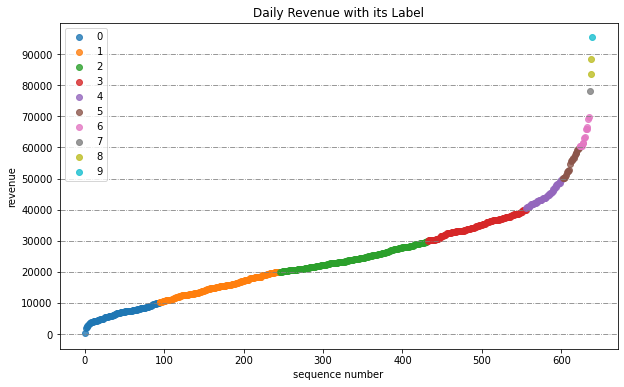

In [7]:
plt.figure(figsize=(10, 6))
total_rev['label'] = total_rev['label'].astype('int')
for i, label in enumerate(total_rev['label'].unique()):
    temp_df = total_rev[total_rev['label'] == label]
    plt.scatter(temp_df['x'],
                temp_df['rev'],
                label=label,
                alpha=0.8)
    plt.axhline(i*10000, linestyle='-.', color='gray', linewidth=0.8)
plt.yticks(np.arange(0, 100000, step=10000))
plt.ylabel('revenue')
plt.xlabel('sequence number')
plt.title('Daily Revenue with its Label')
plt.legend()
plt.savefig('fig/revenue.png', bbox_inches='tight', dpi=100)

In [4]:
# Profile Report

pfr = pandas_profiling.ProfileReport(train_df)
pfr.to_file('report.html')

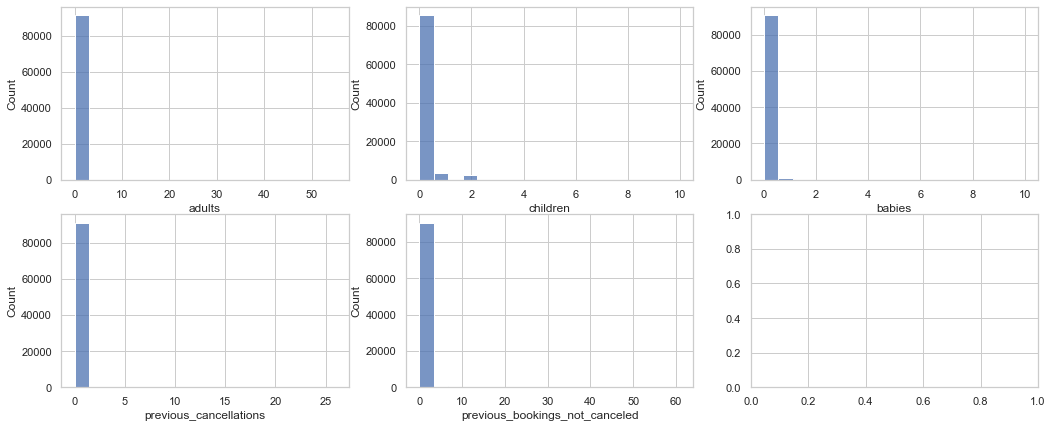

In [52]:
# histogram
sns.set_theme(style='whitegrid')

cols = ['adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled']
n = len(cols)
fig, axes = plt.subplots(2, 3, figsize=(3.5*n, 7))
for i, col in enumerate(cols):
    y_axis = 0
    if i >= 3:
        y_axis = 1
    ax = sns.histplot(train_df[col], ax=axes[y_axis][i%3])
plt.savefig('fig/hist.png', bbox_inches='tight', dpi=100)

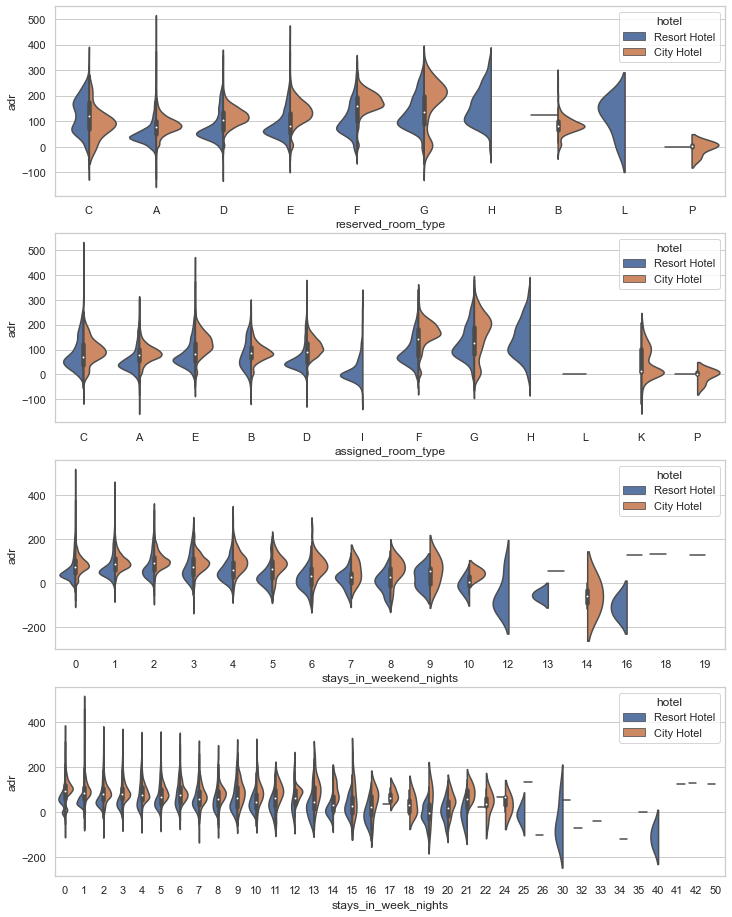

In [21]:
# violin plot w.r.t. adr

sns.set_theme(style='whitegrid')

# cols = ['is_canceled', 'reserved_room_type', 'assigned_room_type',
#        'arrival_date_month', 'arrival_date_week_number', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'market_segment', 'distribution_channel',
#        'is_repeated_guest', 'previous_cancellations',
#        'previous_bookings_not_canceled', 'booking_changes', 'deposit_type', 'required_car_parking_spaces', 'total_of_special_requests']
cols = ['reserved_room_type', 'assigned_room_type','stays_in_weekend_nights', 'stays_in_week_nights']
n = len(cols)
fig, axes = plt.subplots(n, 1, figsize=(12, 4*n))

for i, col in enumerate(cols):
    ax = sns.violinplot(x=col, y='adr', hue='hotel', split=True, data=train_df, ax=axes[i])
#     ax = sns.violinplot(x=col, y='adr', split=True, data=train_df, ax=axes[i])
plt.savefig('fig/violin.png', bbox_inches='tight', dpi=100)

# Handle Missing Values

The PMS assured no missing data exists in its database tables. However, in some categorical
variables like **Agent** or **Company**, “NULL” is presented as one of the categories. This should not be
considered a missing value, but rather as “not applicable”. For example, if a booking “Agent” is defined as “NULL” it means that the booking did not came from a travel agent.

In [6]:
# numbr of unique values w.r.t. categorical features

X.select_dtypes(exclude='number').nunique()

hotel                        2
arrival_date_month          12
meal                         5
country                    177
market_segment               8
distribution_channel         5
reserved_room_type          10
assigned_room_type          12
deposit_type                 3
customer_type                4
reservation_status           3
reservation_status_date    774
dtype: int64

In [53]:
# numbr of unique values w.r.t. numerical features

X.select_dtypes(include='number').nunique()

lead_time                         479
arrival_date_year                   3
arrival_date_week_number           53
arrival_date_day_of_month          31
stays_in_weekend_nights            17
stays_in_week_nights               35
adults                             14
children                            5
babies                              5
is_repeated_guest                   2
previous_cancellations             15
previous_bookings_not_canceled     73
booking_changes                    21
agent                             333
company                           352
days_in_waiting_list              128
required_car_parking_spaces         5
total_of_special_requests           6
dtype: int64

## Imputataion

In [54]:
percentage = X.isna().sum() / len(X)
percentage[percentage != 0]

children                   0.000034
country                    0.004087
agent                      0.136862
company                    0.943069
reservation_status         0.233345
reservation_status_date    0.233345
dtype: float64


* Thus, we drop the row in training dataset with missing value in children and country.  
* Missing values in country in test dataset will replace to mode (PRT).  
* Missing values in agent and company will be considered a new category.

(Missing values in country may be a new feature)

In [55]:
train_df.drop(train_df[train_df['country'].isna()].index, inplace=True)
train_df.drop(train_df[train_df['children'].isna()].index, inplace=True)
train_df['agent'].fillna('-1', inplace=True)
train_df['company'].fillna('-1', inplace=True)

test_df['country'].fillna(train_df['country'].mode()[0], inplace=True)
test_df['agent'].fillna('-1', inplace=True)
test_df['company'].fillna('-1', inplace=True)

In [56]:
train_df.drop(columns = ['reservation_status', 'reservation_status_date'], inplace=True)
train_df.to_csv('train_tree.csv')
test_df.to_csv('test_tree.csv')

## Reduce the categories in several features

In [57]:
train_df.nunique().sort_values(ascending=False)

adr                               90917
lead_time                           452
company                             326
agent                               301
country                             163
days_in_waiting_list                114
previous_bookings_not_canceled       62
arrival_date_week_number             53
stays_in_week_nights                 33
arrival_date_day_of_month            31
booking_changes                      20
stays_in_weekend_nights              15
previous_cancellations               15
adults                               14
arrival_date_month                   12
assigned_room_type                   11
reserved_room_type                    9
market_segment                        7
total_of_special_requests             6
required_car_parking_spaces           5
distribution_channel                  5
meal                                  5
babies                                5
children                              5
customer_type                         4


In [58]:
cum_agent = np.cumsum((train_df['agent'].value_counts() / len(train_df)).sort_values(ascending=False)).iloc[:15]
print(cum_agent)

replace_agent = {}
for category in train_df['agent'].unique():
    if category in cum_agent.index:
        replace_agent[category] = category
    else:
        replace_agent[category] = 'others'

for category in test_df['agent'].unique():
    if category not in replace_agent:
        replace_agent[category] = 'others'
        
train_df['agent'].replace(replace_agent, inplace=True)
test_df['agent'].replace(replace_agent, inplace=True)

9.0      0.246458
-1       0.388049
240.0    0.501351
1.0      0.579345
7.0      0.609260
6.0      0.638275
14.0     0.664587
250.0    0.686672
28.0     0.701608
3.0      0.714621
241.0    0.727306
8.0      0.739935
37.0     0.751389
19.0     0.760263
21.0     0.768818
Name: agent, dtype: float64


In [59]:
# binary

cum_company = np.cumsum((train_df['company'].value_counts() / len(train_df)).sort_values(ascending=False)).iloc[:15]
print(cum_company)

train_df['company'] = (train_df['company'] == '-1').astype('int')
test_df['company'] = (test_df['company'] == '-1').astype('int')

-1       0.940159
40.0     0.948912
223.0    0.956105
67.0     0.959037
45.0     0.961255
174.0    0.962727
281.0    0.964166
153.0    0.965571
405.0    0.966867
233.0    0.968119
219.0    0.969327
154.0    0.970502
51.0     0.971524
47.0     0.972259
94.0     0.972973
Name: company, dtype: float64


In [60]:
cum_country = np.cumsum((train_df['country'].value_counts() / len(train_df)).sort_values(ascending=False)).iloc[:15]
print(cum_country)

replace_country = {}
for category in train_df['country'].unique():
    if category in cum_country.index:
        replace_country[category] = category
    else:
        replace_country[category] = 'others'

for category in test_df['country'].unique():
    if category not in replace_country:
        replace_country[category] = 'others'        

train_df['country'].replace(replace_country, inplace=True)
test_df['country'].replace(replace_country, inplace=True)

PRT    0.442959
GBR    0.534527
FRA    0.621626
ESP    0.696446
DEU    0.752257
ITA    0.784566
IRL    0.809605
BRA    0.827198
NLD    0.844637
BEL    0.861802
USA    0.876397
CHE    0.888994
AUT    0.898779
CHN    0.907334
CN     0.915537
Name: country, dtype: float64


# Feature Transformation
* hotel: binary

In [61]:
train_df['hotel'] = (train_df['hotel'] == 'Resort Hotel').astype('int')
test_df['hotel'] = (test_df['hotel'] == 'Resort Hotel').astype('int')

* arrival_date_month, arrival_date_week_number, arrival_date_day_of_month: cos, sin  
[encoding-cyclical-features](https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning)

In [62]:
# # convert January, ..., December to 1, ..., 12
# train_df['arrival_date_month'] = pd.to_datetime(train_df['arrival_date_month'], format='%B').dt.strftime('%m').astype('int')
# test_df['arrival_date_month'] = pd.to_datetime(test_df['arrival_date_month'], format='%B').dt.strftime('%m').astype('int')

In [63]:
# def cyclically_encode(data, col, max_val):
#     data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
#     data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
#     return data

# cols = ['arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month']
# max_vals = [max(train_df[col]) for col in cols]

# for col, max_val in zip(cols, max_vals):
#     train_df = cyclically_encode(train_df, col, max_val)
#     test_df = cyclically_encode(test_df, col, max_val)

# train_df.drop(columns=cols + ['arrival_date_year'], inplace=True)
# test_df.drop(columns=cols + ['arrival_date_year'], inplace=True)


# leave 'arrival_date_month' to create dummy variable for seasonality
cols = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month']
train_df.drop(columns=cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

* meal, country, market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type, agent, customer_type: one-hot encoding
    - Note that in training data, room_type 'L' doesn't appear in test dataset. And in test dataset, room_type 'P' doesn't appear in training dataset. Here, we covert both of them to 'others'.
    - The categroy 'Undefined' in 'distribution_channel' doesn't appear in test dataset, so we add a all-0 column in test dataset.

In [64]:
train_df['assigned_room_type'].replace({'L': 'others'}, inplace=True)
train_df['reserved_room_type'].replace({'L': 'others'}, inplace=True)

test_df['assigned_room_type'].replace({'P': 'others'}, inplace=True)
test_df['reserved_room_type'].replace({'P': 'others'}, inplace=True)
test_df['distribution_channel_Undefined'] = np.zeros(len(test_df))

# Feature Generation
train_df['is_same_room_type'] = (train_df['assigned_room_type'] == train_df['reserved_room_type']).astype('int')
test_df['is_same_room_type'] = (test_df['assigned_room_type'] == test_df['reserved_room_type']).astype('int')

train_linear = pd.get_dummies(train_df)
test_linear = pd.get_dummies(test_df)

for col in set(train_linear.columns) - set(test_linear.columns):
    if 'arrival_date_month' in col:
        test_linear[col] = [0] * len(test_linear)

train_linear.to_csv('train_linear.csv')
test_linear.to_csv('test_linear.csv')

print('Columns')
print('train - test:', set(train_linear.columns) - set(test_linear.columns))
print('test - train:', set(test_linear.columns) - set(train_linear.columns))

Columns
train - test: {'adr', 'is_canceled'}
test - train: set()


# Feature Engineering

cols = 'is_canceled', 'reserved_room_type', 'assigned_room_type', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'market_segment', 'distribution_channel',
'is_repeated_guest', 'previous_cancellations',
'previous_bookings_not_canceled', 'booking_changes', 'deposit_type', 'required_car_parking_spaces', 'total_of_special_requests'

numerical
 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_bookings_not_canceled', 'previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests'

categorical
 'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest',

In [65]:
def generate_feature(df):
    df['total_people'] = df['adults'] + df['children'] + df['babies']
    
    # log transformation for highly-skewed features
    cols = ['adults', 'children', 'babies', 'total_people', 'previous_cancellations', 'previous_bookings_not_canceled']
    for col in cols:
        df[f'log_{col}'] = np.log(df[col] + 1)  # add 1 to avoid log 0
    
    all_room_type = []
    for col in df.columns:
        if 'reserved_room' in col or 'assigned_room' in col:
            all_room_type.append(col)
    
    num_col = ['stays_in_weekend_nights',
               'stays_in_week_nights',
               'log_adults',
               'log_children',
               'log_babies',
               'log_total_people',
               'log_previous_bookings_not_canceled',
               'log_previous_cancellations',
               'adults',
               'children',
               'babies',
               'total_people',
               'previous_bookings_not_canceled',
               'previous_cancellations',
               'booking_changes',
               'required_car_parking_spaces',
               'total_of_special_requests']
    
    cat_col = []
    for col in df.columns:
        if ('meal' in col) or ('market_segment') in col or ('distribution_channel'in col) or ('is_repeated_guest' in col):
            cat_col.append(col)

    for hotel in [1, 0]:
        mask = (df['hotel']==hotel)
        for col in all_room_type:
            df[f'hotel_{str(hotel)}_' + col] = mask * df[col]
            
            for category in ['log_adults', 'log_children', 'log_babies', 'log_total_people']:
                df[f'hotel_{str(hotel)}_{col}_{category}'] =  df[f'hotel_{str(hotel)}_' + col] * df[category]
        
        for col in num_col + cat_col:
            df[f'hotel_{str(hotel)}_' + col] = mask * df[col]
        
    return df

In [66]:
# Feature Generation

train_linear = pd.read_csv('train_linear.csv', index_col='ID')
test_linear = pd.read_csv('test_linear.csv', index_col='ID')

train_linear_eng = generate_feature(train_linear)
test_linear_eng = generate_feature(test_linear)

# drop all zero columns in training data
train_linear_eng = train_linear_eng.loc[:, (train_linear_eng != 0).any(axis=0)]

# drop all columns that are not appear in training data
to_del_col = []
for col in test_linear_eng.columns:
    if col not in train_linear_eng:
        to_del_col.append(col)
    
test_linear_eng.drop(columns=to_del_col, inplace=True)

train_linear_eng = train_linear_eng.sort_index(axis=1)
test_linear_eng = test_linear_eng

print('Columns')
print('train - test:', set(train_linear_eng.columns) - set(test_linear_eng.columns))
print('test - train:', set(test_linear_eng.columns) - set(train_linear_eng.columns))

Columns
train - test: {'adr', 'is_canceled'}
test - train: set()


In [68]:
X_train_std.shape

(91058, 340)

In [67]:
# Standardization
from sklearn.preprocessing import StandardScaler

y_train_clf = train_linear['is_canceled']
y_train_reg = train_linear['adr']

# sort the dataframe w.r.t. columns names
X_train = train_linear_eng.drop(columns=['is_canceled', 'adr']).sort_index(axis=1)
X_test = test_linear_eng.sort_index(axis=1) 

# no need to standardize binary variables
bin_col = X_train.columns[X_train.nunique() == 2]
non_bin_col = X_train.columns.difference(bin_col)

scaler = StandardScaler().fit(X_train[non_bin_col])
X_train_std = pd.DataFrame(scaler.transform(X_train[non_bin_col]), columns=non_bin_col, index=X_train.index)
X_test_std = pd.DataFrame(scaler.transform(X_test[non_bin_col]), columns=non_bin_col, index=X_test.index)

X_train_std = pd.concat([X_train[bin_col], X_train_std], axis=1)
X_test_std = pd.concat([X_test[bin_col], X_test_std], axis=1)

# --- separated way ---
# train_index_0 = train_linear['hotel'] == 0
# train_index_1 = train_linear['hotel'] == 1

# test_index_0 = test_linear['hotel'] == 0
# test_index_1 = test_linear['hotel'] == 1

# y_train_sep = [train_linear[train_index_0]['is_canceled'],
#                train_linear[train_index_1]['is_canceled']]

# X_train_sep = [train_linear[train_index_0].drop(columns=['hotel', 'is_canceled', 'adr']),
#                train_linear[train_index_1].drop(columns=['hotel', 'is_canceled', 'adr'])]

# X_test_sep = [test_linear[test_index_0].drop(columns=['hotel']),
#               test_linear[test_index_1].drop(columns=['hotel'])]

# for i in range(len(X_train_sep)):
#     df_train = X_train_sep[i]
#     df_train = df_train.loc[:, (df_train != 0).any(axis=0)]
    
#     df_test = X_test_sep[i][df_train.columns]
    
#     scaler = StandardScaler().fit(df_train)
#     X_train_sep[i] = scaler.transform(df_train)
#     X_test_sep[i] = scaler.transform(df_test)      

# X_train = train_linear_eng.drop(columns=['is_canceled', 'adr'])
# X_test = test_linear_eng

# scaler = StandardScaler().fit(X_train)
# X_train_std = scaler.transform(X_train)
# X_test_std = scaler.transform(X_test)

In [72]:
temp = pd.read_csv('train_tree.csv', index_col=0)
# temp['adr'] = y_train_reg
col = list(temp.columns)
col.remove('adr')
col.remove('arrival_date_year')
col.remove('arrival_date_month')
col.remove('arrival_date_week_number')
col.remove('arrival_date_day_of_month')
grouped = temp.groupby(col)

In [73]:
df_ = []
for name, group in grouped:
    if len(df_) == 10:
        break
    if len(group) >= 10:
        df_.append(group)


# Model
## is_canceled
LogisticRegression(C=0.01, l1_ratio=0.6000000000000001, n_jobs=-1,
                   penalty='elasticnet', solver='saga', verbose=1)

### Feature Selection

In [110]:
lr = LogisticRegression(C=0.01,
                        l1_ratio=0.6,
                        max_iter=4000,
                        n_jobs=-1,
                        penalty='elasticnet',
                        solver='saga',
                        verbose=1).fit(X_train_std, y_train_clf)
selector = SelectFromModel(lr, prefit=True)
X_train_clf = selector.transform(X_train_std)
X_test_clf = selector.transform(X_test_std)

print(X_train.columns[selector.get_support()])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 2447 epochs took 2296 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 38.3min finished


Index(['adults', 'agent_21.0', 'agent_6.0', 'agent_8.0',
       'arrival_date_month_January', 'arrival_date_month_November',
       'assigned_room_type_others', 'booking_changes', 'children',
       'country_AUT', 'country_BRA', 'country_CHE', 'country_CHN',
       'country_CN', 'country_ESP', 'country_FRA', 'country_GBR',
       'country_ITA', 'country_NLD', 'country_USA', 'customer_type_Contract',
       'customer_type_Group', 'days_in_waiting_list',
       'hotel_0_log_previous_bookings_not_canceled',
       'hotel_0_market_segment_Offline TA/TO',
       'hotel_0_reserved_room_type_C_log_total_people',
       'hotel_0_reserved_room_type_D', 'hotel_0_reserved_room_type_E',
       'hotel_0_reserved_room_type_E_log_adults',
       'hotel_0_reserved_room_type_E_log_babies',
       'hotel_0_reserved_room_type_F_log_children', 'hotel_1_adults',
       'hotel_1_assigned_room_type_A_log_total_people',
       'hotel_1_assigned_room_type_H_log_total_people',
       'hotel_1_assigned_room_type

In [111]:
pd.DataFrame(X_train_clf, columns=X_train.columns[selector.get_support()]).to_csv('X_train_clf.csv')
pd.DataFrame(X_test_clf, columns=X_train.columns[selector.get_support()]).to_csv('X_test_clf.csv')

### CV

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 0, 1, 10, 100, 1000],
              'l1_ratio': np.arange(0.0, 1.1, 0.1)}

tscv = TimeSeriesSplit(n_splits = 5)
lr = LogisticRegression(penalty='elasticnet', n_jobs=-1, verbose=1, solver='saga')
clf = GridSearchCV(lr, param_grid, cv=tscv, scoring = 'accuracy')
clf.fit(X_train_sel, y_train_clf)

In [110]:
X = X_train_clf
y = y_train_clf

param_grid = {}

tscv = TimeSeriesSplit(n_splits = 10)
lr = LogisticRegression(C=0.01,
                           l1_ratio=0.6,
                           max_iter=500,
                           n_jobs=-1,
                           penalty='elasticnet',
                           solver='saga',
                           verbose=1)
clf = GridSearchCV(lr, param_grid, cv=tscv, scoring = 'accuracy', n_jobs=-1, refit=False)
clf.fit(X, y)
result.append(clf)

# test for feature engineering

# result = []
# for X, y in zip(X_train_sep, y_train_sep):
#     param_grid = {}

#     tscv = TimeSeriesSplit(n_splits = 10)
#     lr = LogisticRegression(C=0.01,
#                            l1_ratio=0.6,
#                            max_iter=500,
#                            n_jobs=-1,
#                            penalty='elasticnet',
#                            solver='saga',
#                            verbose=1)
#     clf = GridSearchCV(lr, param_grid, cv=tscv, scoring = 'accuracy')
#     clf.fit(X, y)
#     result.append(clf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   40.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

max_iter reached after 75 seconds


C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed

max_iter reached after 58 seconds


C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   57.6s finished


### Predict

In [147]:
lr = LogisticRegression(C=0.01,
                        l1_ratio=0.6,
                        max_iter=500,
                        n_jobs=-1,
                        penalty='elasticnet',
                        solver='saga',
                        verbose=1).fit(X_train_clf, y_train_clf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 126 epochs took 15 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished


In [156]:
prob_predict = lr.predict_proba(X_test_clf)[:, 0]
pd.Series(prob_predict).to_csv('output/result_prob_logistic_acc_0.812.csv')

## adr
### Feature Selection

In [77]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

# Polynomial Features Transform (Q=2)
# poly = PolynomialFeatures(degree=2, interaction_only=True)
# X_train_std = poly.fit_transform(X_train_std)

lasso = Lasso().fit(X_train_std, y_train_reg)
selector = SelectFromModel(lasso, prefit=True)
X_train_reg = selector.transform(X_train_std)
X_test_reg = selector.transform(X_test_std)
print(X_train.columns[selector.get_support()])

Index(['agent_-1.0', 'agent_8.0', 'arrival_date_month_April',
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_June',
       'arrival_date_month_October', 'hotel_0_meal_BB',
       'hotel_0_reserved_room_type_D_log_total_people',
       'hotel_0_reserved_room_type_E_log_babies',
       'hotel_0_reserved_room_type_F',
       'hotel_1_assigned_room_type_D_log_babies',
       'hotel_1_assigned_room_type_E_log_total_people',
       'hotel_1_assigned_room_type_F_log_children',
       'hotel_1_assigned_room_type_F_log_total_people', 'hotel_1_children',
       'hotel_1_distribution_channel_TA/TO', 'hotel_1_log_babies',
       'hotel_1_log_total_people', 'hotel_1_market_segment_Online TA',
       'hotel_1_meal_BB', 'hotel_1_reserved_room_type_B_log_total_people',
       'hotel_1_reserved_room_type_D_log_children',
       'hotel_1_reserved_room_type_F',
       'hotel_1_reserved_room_type_F_log_babies',
       'hotel_1_

In [113]:
pd.DataFrame(X_train_reg, columns=X_train.columns[selector.get_support()]).to_csv('X_train_reg.csv')
pd.DataFrame(X_test_reg, columns=X_train.columns[selector.get_support()]).to_csv('X_test_reg.csv')

### CV

In [132]:
pandas_profiling.ProfileReport(pd.DataFrame(X_train_reg, columns=X_train.columns[selector.get_support()])).to_file('X_train_reg_report.html')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

X = X_train_reg
y = y_train_reg

param_grid = {}

tscv = TimeSeriesSplit(n_splits = 5)
# estimator = LinearRegression()
# estimator = Ridge()
# estimator = Lasso()
# estimator = XGBRegressor()
estimator = KNeighborsRegressor()

reg = GridSearchCV(estimator, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3, refit=False)
reg.fit(X, y)

In [125]:
reg.cv_results_

{'mean_fit_time': array([16.90068121]),
 'std_fit_time': array([6.7406168]),
 'mean_score_time': array([0.03962643]),
 'std_score_time': array([0.00984713]),
 'params': [{}],
 'split0_test_score': array([-2254.46621336]),
 'split1_test_score': array([-896.02440542]),
 'split2_test_score': array([-491.02138298]),
 'split3_test_score': array([-577.35960961]),
 'split4_test_score': array([-1077.64514412]),
 'split5_test_score': array([-1630.69142296]),
 'split6_test_score': array([-1017.34061238]),
 'split7_test_score': array([-679.60295384]),
 'split8_test_score': array([-805.30577628]),
 'split9_test_score': array([-427.09799716]),
 'mean_test_score': array([-985.65555181]),
 'std_test_score': array([537.86623374]),
 'rank_test_score': array([1])}

1/4
* linear: -4.13262343e+23
* Ridge: -1532.9625362
* Lasso: -1547.58009368
* XGBRegressor: -1716.01527149

1/7
* linear: -1.83092378e+24
* Ridge: -1262.86597915
* Lasso: -1513.1613633
* XGBRegressor: -985.65555181

---
5 fold below:  

1/9

### Predict

In [120]:
# Linear Regeression

linearReg = Ridge().fit(X, y)
adr_pred = linearReg.predict(X_test_reg)
pd.Series(adr_pred).to_csv('output/result_adr_ridge_MSE_1262.86597915.csv')

In [126]:
# XgBoost
from xgboost import XGBRegressor

xgb = XGBRegressor().fit(X, y)
adr_pred = xgb.predict(X_test_reg)
pd.Series(adr_pred).to_csv('output/result_adr_xgb_MSE_985.65555181.csv')

# Generate Label
combinne 'is_canceled' and 'adr' with stayed nights

try integer or float

In [14]:
version = '14'
prob_name = 'result_prob_xgboost1230 penalty=2 acc=84.6.csv'
adr_name = 'adr_Xreg_results/DNN_Xreg_scaled_MSE2903_epoch200.csv'

# ------------------------------------------------------------------
rev_pred = pd.read_csv('test_datetime.csv').drop(columns=['ID'])
test_linear = pd.read_csv('test_linear.csv')
is_pred = pd.read_csv('output/' + prob_name)['0']
adr_pred = pd.read_csv('output/' + adr_name)['adr']
rev_pred['rev'] = (is_pred) * adr_pred * (test_linear['stays_in_weekend_nights'] +
                                          test_linear['stays_in_week_nights'])
rev_pred['datetime'] = pd.to_datetime(rev_pred['datetime'])

rev_pred = rev_pred.groupby('datetime').sum()
rev_pred.sort_values(by='datetime', inplace=True)
rev_pred['label'] = rev_pred['rev'] // 10000

result = pd.read_csv('test_nolabel.csv')
result['label'] = rev_pred['label'].to_numpy()
result['label'] = np.where(result['label'] > 9, 9, result['label'])

result.to_csv('output/test_' + version + '.csv', index=False)